### TODO
- [ ] nodeをきれいにレイアウトする
- [ ] サンプルをどうやって選ぶ？？

In [3]:
%matplotlib inline
import requests, json, re, pickle
import pandas as pd
import networkx as nx
from datetime import datetime as dt
import matplotlib.pyplot as plt
import itertools

In [12]:
repos = [
    'facebook/react', 'tensorflow/tensorflow', 'takipi/java-bullshifier', 'atom/atom', 'adobe/brackets', 'microsoft/vscode',
    'jaywcjlove/awesome-mac', 'SwiftyWang/FingerColoring-Android', 'huacnlee/flora-kit', 'alibaba/BeeHive', 'vuejs/vue',
    'jpuri/react-draft-wysiwyg', 'andrew--r/channels', 'googlesamples/md2googleslides', 'j-delaney/easy-application',
    'FreeCodeCamp/FreeCodeCamp', 'BendingSpoons/katana-swift', 'phillipi/pix2pix', 'Developer-Y/cs-video-courses'
]

In [1]:
# dataset = []
# for repo in repos:
#     dataset.append(formatted_data(repo))

In [18]:
save_as_pickle('repos_data.pkl', dataset)

In [14]:
basic_data = [d["basic"] for d in dataset]

In [16]:
save_to_csv(basic_data, 'basic_data.csv')

### Functions

In [42]:
API_ROOT = 'https://api.github.com'
API_TOKEN = '6e7fe2b9d8c6da31a832de88eb69922e63c04f9b'
USER = 'Takamichi-tsutsumi'

class NoRepositoryError(Exception):
    pass
    
def str2dt(tstr):
    return dt.strptime(tstr, '%Y-%m-%dT%H:%M:%SZ')

def api_get(url):
    """
    @args: url
    $return: dict res, int status
    """
    global API_TOKEN, USER
    res = requests.get(url, auth=(USER, API_TOKEN))
    return res.json(), res.status_code

def rate_limit():
    global API_ROOT
    res, _ = api_get(API_ROOT + '/rate_limit')
    return res["resources"]["core"]["remaining"]

def get_repo(repo):
    """repo have to be shape of 'owner/name' """
    repo_pattern = re.compile('[a-zA-Z0-9-]+\/[a-zA-Z0-9-]+$')
    m = repo_pattern.match(repo)
    assert m.group() == repo
    global API_ROOT
    url = API_ROOT + '/repos/' + repo
    res, status  = api_get(url)
    if status == 404:
        raise NoRepositoryError("Repository not found: " + repo)
    return res

def basic_data_of(repo):
    repo_res = get_repo(repo)
    data = {}
    data["repository"] = repo_res["full_name"]
    data["owner_name"] = repo_res["owner"]["login"]
    data["owner_type"] = repo_res["owner"]["type"]
    data["is_fork"] = repo_res["fork"]
    data["size"] = repo_res["size"]
    data["language"] = repo_res["language"]
    data["forks"] = repo_res["forks"]
    data["watchers"] = repo_res["watchers"]
    data["created_at"] = repo_res["created_at"]
    data["pushed_at"] = repo_res["pushed_at"]
    data["age (days)"] = (str2dt(data["pushed_at"]) - str2dt(data["created_at"])).days
    return data

def get_contributors_of(repo, per_page=30, page=1):
    url = API_ROOT + '/repos/' + repo + '/contributors?page=' + str(page) + '&per_page=' + str(per_page)
    print("Start fetching contributors of "+repo)
    res, status = api_get(url)
    if status == 200:
        return res
    else:
        raise NoRepositoryError

def get_orgs_of(user, per_page=30):
    url = API_ROOT + '/users/' + user + '/orgs?per_page=' + str(per_page)
    print("Start fetching orgs of user: " + user)
    res, status = api_get(url)
    orgs = []
    for o in res:
        d = {"id": o["id"], "name": o["login"]}
        orgs.append(d)
    print("done.")
    if status == 200:
        return orgs
    else:
        raise NoRepositoryError
        
def contributors(repo):
    data = []
    contributors = get_contributors_of(repo, per_page=100)
    for c in contributors:
        user = {
            "id": c["id"],
            "name": c["login"],
            "contributions": c["contributions"]
        }
        repos = repos_user_contributed_to(c["login"])
        user["organizations"] = repos
        data.append(user)
    return data

def formatted_data(repo):
    data = {}
    print("Start fetching repository data...")
    data["basic"] = basic_data_of(repo)
    print("Successfully fetched repository data!")
    print("Start fetching contributors data...")
    c = contributors(repo)
    print("Successfully fetched contributors data!")
    data["contributors"] = c
    return data

In [43]:
def repo_url_to_repo(url):
    tokens = url.split("/")
#     print(tokens)
    l = len(tokens)
    return tokens[l-2] + "/" + tokens[l-1]

def is_contributor_of(repo, user):
    n = 100
    i = 1
    all_contributors = []
    while n == 100:
        contributors = get_contributors_of(repo, per_page=100, page=i)
        if user in [c["login"] for c in contributors]:
            return True
        n = len(contributors)
        i += 1
    return False

def repos_user_contributed_to(user):
    issues_url =  API_ROOT + '/search/issues?q=type:pr+author:' + user+ '&per_page=100/page=1'
    res, status = api_get(issues_url)
    if status != 200:
        return []
    else:
        repos =  list(set([repo_url_to_repo(pr['repository_url']) for pr in res["items"]]))
        return [r for r in repos if is_contributor_of(r, user)]

In [36]:
repo_url_to_repo("https://api.github.com/repos/Takamichi-tsutsumi/ChatStormingServerAPI")

['https:', '', 'api.github.com', 'repos', 'Takamichi-tsutsumi', 'ChatStormingServerAPI']


'Takamichi-tsutsumi/ChatStormingServerAPI'

In [40]:
repos_user_contributed_to('Takamichi-tsutsumi')

Start fetching contributors of akotani/letel-web
Start fetching contributors of HiroNonoyama/tsurusenishiguchi_dentalClinic
Start fetching contributors of akotani/letel-font
Start fetching contributors of Takamichi-tsutsumi/onocolo-client
Start fetching contributors of Takamichi-tsutsumi/Meeeal
Start fetching contributors of akotani/letel-rails


['akotani/letel-web',
 'HiroNonoyama/tsurusenishiguchi_dentalClinic',
 'akotani/letel-font',
 'Takamichi-tsutsumi/onocolo-client',
 'Takamichi-tsutsumi/Meeeal']

In [25]:
is_contributor_of("facebook/react", "Takamichi-tsutsumi")

Start fetching contributors of facebook/react
Start fetching contributors of facebook/react
Start fetching contributors of facebook/react
Start fetching contributors of facebook/react
Start fetching contributors of facebook/react


False

In [3]:
def save_as_pickle(file, obj):
    with open(file, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        del obj

In [4]:
def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename)


def save_contributors_of(repo_data):
    df = pd.DataFrame(repo_data["contributors"])
    df.to_csv(repo_data["basic"]["repository"].replace('/', '_') + '.csv')

### Main

In [26]:
print(rate_limit())

4926


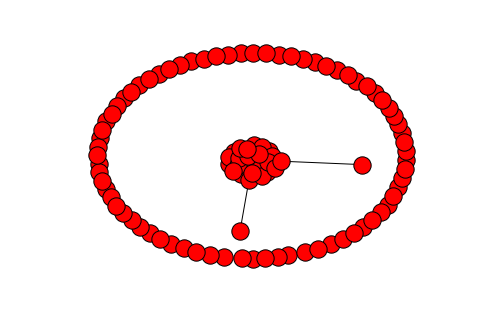

In [36]:
draw_graph(dataset[5]["contributors"])

In [6]:
# pd.DataFrame([basic_data])

In [7]:
# df = pd.DataFrame([r["basic"] for r in dataset])

In [8]:
# pd.DataFrame(dataset[0]["contributors"])

In [9]:
# pd.DataFrame(dataset[1]["contributors"])

In [21]:
def has_connection(cx, cy):
    link = 0
    for i, j in itertools.product(cx["organizations"], cy["organizations"]):
        if i["id"] == j["id"]: link += 1;
    return link

def link_of(contributors):
    links = []
    for cx, cy in itertools.combinations(contributors, 2):
        if has_connection(cx, cy) != 0:
            links.append((cx["name"], cy["name"]))
    return links

def draw_graph(cs):
    labels = [c["name"] for c in cs]
    links = link_of(cs)
    G = nx.Graph()
#     G = nx.watts_strogatz_graph(100, 3, 0.6)
    G.add_nodes_from(labels)
    G.add_edges_from(links)
#     nx.draw_networkx(G, pos=nx.spring_layout(G, scale=3.0), node_size=100, with_labels=False)
    nx.draw(G)
    plt.show()

In [33]:
repo= 'facebook/react'
data = formatted_data(repo)

Start fetching repository data...
Successfully fetched repository data!
Start fetching contributors data...
Start fetching contributors of facebook/react
Start fetching orgs of user: zpao
done.
Start fetching orgs of user: spicyj
done.
Start fetching orgs of user: sebmarkbage
done.
Start fetching orgs of user: jimfb
done.
Start fetching orgs of user: petehunt
done.
Start fetching orgs of user: gaearon
done.
Start fetching orgs of user: chenglou
done.
Start fetching orgs of user: vjeux
done.
Start fetching orgs of user: benjamn
done.
Start fetching orgs of user: subtleGradient
done.
Start fetching orgs of user: yungsters
done.
Start fetching orgs of user: syranide
done.
Start fetching orgs of user: cpojer
done.
Start fetching orgs of user: marocchino
done.
Start fetching orgs of user: acdlite
done.
Start fetching orgs of user: kohei-takata
done.
Start fetching orgs of user: koba04
done.
Start fetching orgs of user: chicoxyzzy
done.
Start fetching orgs of user: mcsheffrey
done.
Start fet

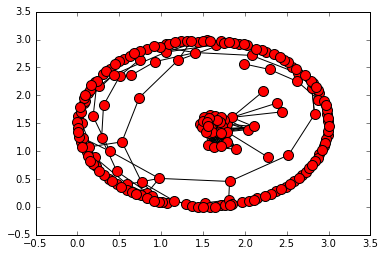

In [40]:
draw_graph(data["contributors"])

In [41]:
repos = ['facebook/react', 'tensorflow/tensorflow', 'atom/atom', 'adobe/brackets', 'microsoft/vscode']

dataset = []
for repo in repos:
    dataset.append(formatted_data(repo))

Start fetching repository data...
Successfully fetched repository data!
Start fetching contributors data...
Start fetching contributors of facebook/react
Start fetching orgs of user: zpao
done.
Start fetching orgs of user: spicyj
done.
Start fetching orgs of user: sebmarkbage
done.
Start fetching orgs of user: jimfb
done.
Start fetching orgs of user: petehunt
done.
Start fetching orgs of user: gaearon
done.
Start fetching orgs of user: chenglou
done.
Start fetching orgs of user: vjeux
done.
Start fetching orgs of user: benjamn
done.
Start fetching orgs of user: subtleGradient
done.
Start fetching orgs of user: yungsters
done.
Start fetching orgs of user: syranide
done.
Start fetching orgs of user: cpojer
done.
Start fetching orgs of user: marocchino
done.
Start fetching orgs of user: acdlite
done.
Start fetching orgs of user: kohei-takata
done.
Start fetching orgs of user: koba04
done.
Start fetching orgs of user: chicoxyzzy
done.
Start fetching orgs of user: mcsheffrey
done.
Start fet

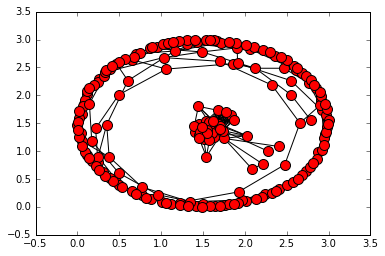

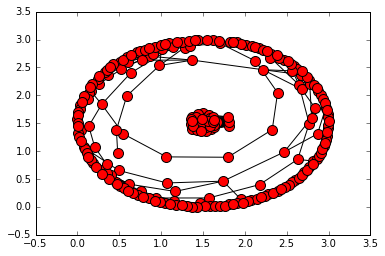

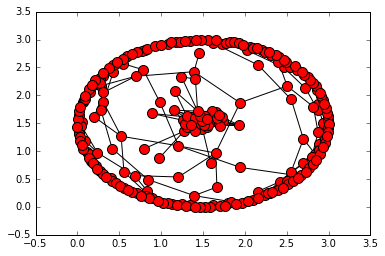

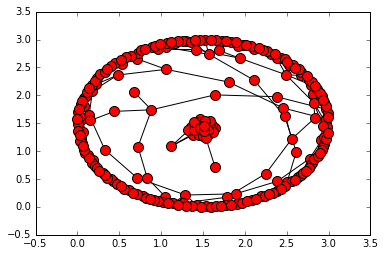

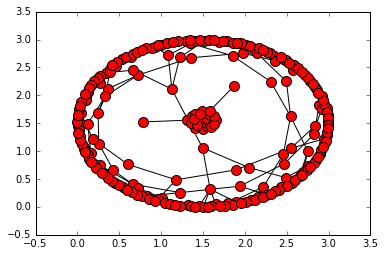

In [42]:
for d in dataset:
    draw_graph(d["contributors"])

Start fetching repository data...
Successfully fetched repository data!
Start fetching contributors data...
Start fetching contributors of jashkenas/backbone
Start fetching orgs of user: jashkenas
done.
Start fetching orgs of user: braddunbar
done.
Start fetching orgs of user: akre54
done.
Start fetching orgs of user: jridgewell
done.
Start fetching orgs of user: caseywebdev
done.
Start fetching orgs of user: tgriesser
done.
Start fetching orgs of user: megawac
done.
Start fetching orgs of user: wyuenho
done.
Start fetching orgs of user: gsamokovarov
done.
Start fetching orgs of user: captbaritone
done.
Start fetching orgs of user: samuelclay
done.
Start fetching orgs of user: philfreo
done.
Start fetching orgs of user: tbranyen
done.
Start fetching orgs of user: thejefflarson
done.
Start fetching orgs of user: krawaller
done.
Start fetching orgs of user: jdalton
done.
Start fetching orgs of user: iros
done.
Start fetching orgs of user: craigmichaelmartin
done.
Start fetching orgs of u

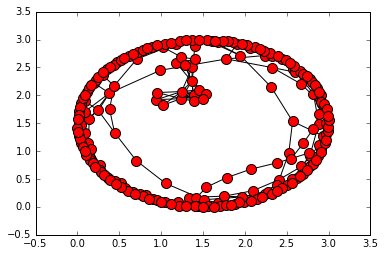

In [43]:
backbone = formatted_data('jashkenas/backbone')
draw_graph(backbone["contributors"])

Start fetching repository data...
Successfully fetched repository data!
Start fetching contributors data...
Start fetching contributors of ruby/ruby
Start fetching orgs of user: nobu
done.
Start fetching orgs of user: akr
done.
Start fetching orgs of user: nurse
done.
Start fetching orgs of user: unak
done.
Start fetching orgs of user: ko1
done.
Start fetching orgs of user: eban
done.
Start fetching orgs of user: drbrain
done.
Start fetching orgs of user: znz
done.
Start fetching orgs of user: knu
done.
Start fetching orgs of user: hsbt
done.
Start fetching orgs of user: kosaki
done.
Start fetching orgs of user: mame
done.
Start fetching orgs of user: zzak
done.
Start fetching orgs of user: shugo
done.
Start fetching orgs of user: tenderlove
done.
Start fetching orgs of user: marcandre
done.
Start fetching orgs of user: kou
done.
Start fetching orgs of user: yugui
done.
Start fetching orgs of user: mrkn
done.
Start fetching orgs of user: nahi
done.
Start fetching orgs of user: nagachik

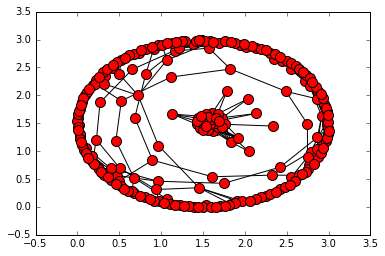

In [46]:
ruby = formatted_data('ruby/ruby')
draw_graph(ruby["contributors"])

In [45]:
rate_limit()

4149